# Getting started with CUDA

## Setup

In [9]:
import torch, os, math 
import fastbook
import torchvision as tv
import torchvision.transforms.functional as tvf
import matplotlib.pyplot as plt


from torch.utils.cpp_extension import load_inline
from fastbook import *

fastbook.setup_book()

%load_ext autoreload
%autoreload 2


In [10]:
img = tv.io.read_image(path = "puppy.jpg")
print(img.shape)
img[:2,:3,:4]

torch.Size([3, 1330, 1920])


tensor([[[225, 225, 225, 225],
         [225, 225, 225, 225],
         [225, 225, 225, 225]],

        [[228, 228, 228, 228],
         [228, 228, 228, 228],
         [228, 228, 228, 228]]], dtype=torch.uint8)

In [11]:
def show_img(x, figsize=(6,4), **kwargs):
    """A method to show the images"""
    plt.figure(figsize=figsize)
    plt.axis('off')
    if len(x.shape)==3: x = x.permute(1,2,0) 
    plt.imshow(x.cpu(), **kwargs)

# if you have a tensor x with shape (3, 1330, 1920) (dimensions (0, 1, 2)), applying x.permute(1, 2, 0) will rearrange the dimensions to (1330, 1920, 3) (dimensions (1, 2, 0)).

# So, after the permute, the shape of x becomes (1330, 1920, 3). This is often done to make the tensor compatible with libraries like matplotlib, which expects the color channel to be the last dimension.



#### A short example to understand permute

In [12]:
x = torch.tensor([
    [[1,  2,  3,  4],    # batch 0, row 0
     [5,  6,  7,  8],    # batch 0, row 1
     [9, 10, 11, 12]],   # batch 0, row 2

    [[13, 14, 15, 16],   # batch 1, row 0
     [17, 18, 19, 20],   # batch 1, row 1
     [21, 22, 23, 24]]   # batch 1, row 2
])

print("Original shape:", x.shape)  # torch.Size([2, 3, 4])


Original shape: torch.Size([2, 3, 4])


In [13]:
sum0 = x.sum(dim=0)
# sum0
# tensor([
#  [ 1+13,  2+14,  3+15,  4+16],    # row 0
#  [ 5+17,  6+18,  7+19,  8+20],    # row 1
#  [ 9+21, 10+22, 11+23, 12+24]     # row 2
# ])
# → tensor([
#     [14, 16, 18, 20],
#     [22, 24, 26, 28],
#     [30, 32, 34, 36]
# ])
print(sum0)

# extra info on how the sum works with dim / axes 
sum1 = x.sum(dim=1)
# sum1 
# tensor
print(sum1)

tensor([[14, 16, 18, 20],
        [22, 24, 26, 28],
        [30, 32, 34, 36]])
tensor([[15, 18, 21, 24],
        [51, 54, 57, 60]])


In [14]:
# switching batch and rows 
x_perm = x.permute(1, 0, 2)  # shape becomes (3, 2, 4)
print("Permuted shape:", x_perm.shape)

Permuted shape: torch.Size([3, 2, 4])


In [15]:
sum_prem0 = x.sum(dim=0)
# sum_prem0
# tensor([
#  [ 1+5+9,   2+6+10,  3+7+11,  4+8+12],   # original batch 0
#  [13+17+21,14+18+22,15+19+23,16+20+24]   # original batch 1
# ])
# → tensor([
#     [15, 18, 21, 24],
#     [51, 54, 57, 60]
# ])
print(sum_prem0)

tensor([[14, 16, 18, 20],
        [22, 24, 26, 28],
        [30, 32, 34, 36]])


### resizing the image

In [16]:
img2 = tvf.resize(img, 150, antialias=True)
# ch - channel (rgb)
# h - height
# w - width
ch,h,w = img2.shape
ch,h,w,h*w

(3, 150, 216, 32400)

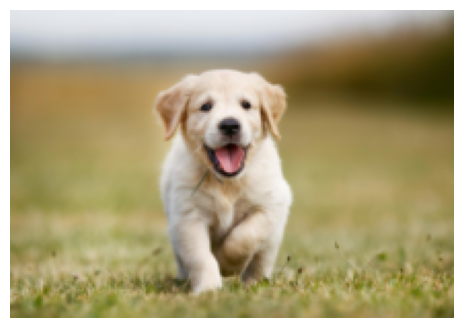

In [17]:
show_img(img2)

## RGB -> Grey

### Basic python

In [18]:
def rgb2grey(x):
    """This method converts the rgb image to a grey
    how it does it: 
    we first flatten the image and then multipy it by the values to convert it into grey"""
    c,h,w = x.shape
    n = h*w
    x = x.flatten() # reshape to 1-d tensor 
    res = torch.empty(n, dtype=x.dtype, device=x.device)
    for i in range(n): res[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n]
    return res.view(h,w)

In [19]:
# why did we flatten the image - to make the code faster

In [20]:
# rgb -> grey =   r*0.21 + g*0.72 + b*0.07  
# img2.shape =  torch.Size([3, 150, 216]) this means we have 3 matrix each of row , column(150, 216) 
# 3 matrix representing 0 - red, 1-green, 2-blue
# so when we are going to flatten the image all the values of the red will comes first then green and then blue 
# how many values of red are - how many pixed (h*w) or (row*column)
# so now our formula for converting to grey image changes to 
# x[i]*0.21 + x[i+n]*0.72 + x[i+2*n]*0.07 where n is (h*w) and x is the flattened image


In [21]:
%%time 
img_g = rgb2grey(img2)

CPU times: user 1.43 s, sys: 0 ns, total: 1.43 s
Wall time: 1.45 s


This is very slow 2seconds for one image what if we have 1000 of images

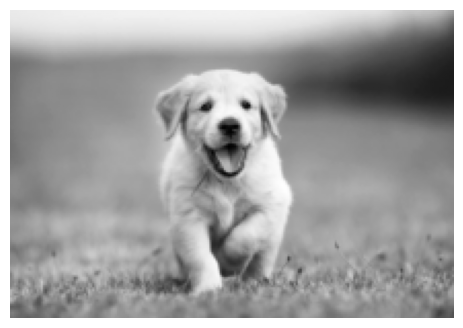

In [22]:
show_img(img_g, cmap='grey')

### Some key points

1. **Streaming Multiprocessors (SMs):** In NVIDIA GPUs, SMs are the fundamental units of execution. Each SM can execute multiple threads concurrently.
2. **Thread Blocks:** A thread block is a group of threads that can cooperate among themselves through shared memory and synchronization. All threads in a block are executed on the same SM. This means they can share resources such as shared memory and can synchronize their execution with each other.
3. **Shared Memory:** Shared memory is a small memory space on the GPU that is shared among the threads in a block. It is much faster than global memory (the main GPU memory), but it is also limited in size. Threads in the same block can use shared memory to share data with each other efficiently.

- The RTX 3090, based on the Ampere architecture, has 82 SMs.
- Each SM in GA10x GPUs contain 128 CUDA Cores, four third-generation Tensor Cores, a 256 KB Register File, and 128 KB of L1/Shared Memory
- In CUDA, all threads in a block have the potential to run concurrently. However, the actual concurrency depends on the number of CUDA cores per SM and the resources required by the threads.

In [23]:
82*128 # 10496 cores to run our program parallelly

10496

### Python Kernel

In [ ]:
# how to do it how to use all the cores simulatenlousy 
# to do so we will change a part of our code 
# "res[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n]" 
# we will make this as function that can be run in different cores as it something that can run parallely

In [25]:
def run_kernel(f, times, *args):
    for i in range(times): f(i, *args)

>**NOTE: A kernel cannot return anything. it can only change contents of things passed to it**

In [26]:
# write a function and in your function write the line of code which i am gonna call as many times as nesecary
# to do all the work needed and i will do it as much parallel based on the number of cores 
# A kernel cannot return anything. it can only change contents of things passed to it

def rgb2grey_k(i:int, x:torch.tensor, out:torch.tensor, n:int):
    """
    i:int - Index 
    x:torch.tensor - A 1-d tensor of the image 
    out:torch.tensor - A empty tensor of size n , dtype as x 
    n:int - Number of pixels
    """
    out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n]

In [27]:
def rgb2grey_pyk(x):
    c,h,w = x.shape
    x = x.flatten()
    n = h*w
    res = torch.empty(n, dtype=x.dtype, device=x.device)
    run_kernel(rgb2grey_k, h*w, x, res, n)
    return res.view(h,w)

In [ ]:
%%time
img_g = rgb2grey_pyk(img2)


# The above code simulates the cuda login in python this doesn't happens in parallel so it doens't speeds 
# any thing up

CPU times: user 1.34 s, sys: 0 ns, total: 1.34 s
Wall time: 1.33 s


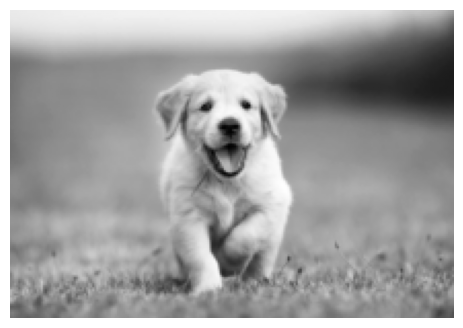

In [30]:
show_img(img_g, cmap='gray')

### Python Block Kernel

In [35]:
# Why block so in cuda the thread are group together into block they have shared memory and sychronization 
# and each block on same sm and shared memory is much faster than global memory 

# so now instead of having one loop we will have 2 one looping through all the block and one looping through all the thread in each block 

def blk_kernel(f, blocks, threads, *args):
    for i in range(blocks): 
        for j in range(threads): 
            f(i, j, threads, *args)

In [36]:
def rgb2grey_bk(blockidx, threadidx, blockdim, x, out, n):
    i = blockidx*blockdim + threadidx
    if i<n: out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n]


In [37]:
def rgb2grey_pybk(x):
    c,h,w = x.shape
    n = h*w
    x = x.flatten()
    res = torch.empty(n, dtype=x.dtype, device=x.device)
    threads= 256
    blocks = int(math.ceil(h*w/threads))
    blk_kernel(rgb2grey_bk, blocks, threads, x , res, n)
    return res.view(h,w)

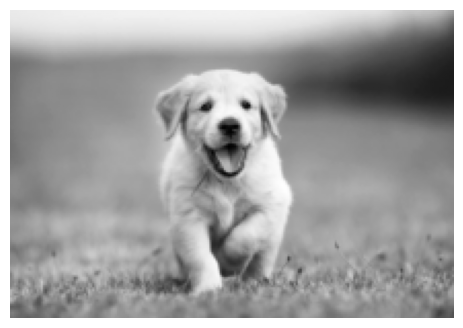

In [39]:
img_2 = rgb2grey_pybk(img2)
show_img(img_2, cmap='gray')

### CUDA Setup